In [ ]:
import os

import cv2
import matplotlib.pyplot as plt
import pandas as pd
import psutil

import spatioloji_s as sj

In [2]:
mem = psutil.virtual_memory()
print(f"Total memory available: {mem.total / 1024**3:.2f} GB")
cpus = os.cpu_count()
print(f"Total cpu cores available: {cpus}")
print(f"current work directory is {os.getcwd()}")

Total memory available: 251.40 GB
Total cpu cores available: 64
current work directory is /carc/scratch/projects/amitra2016502/spatioloji_s/example


In [3]:
# prepare folder paths
data_read = '../../CosMx/OV/' # for raw data
data_save = '../../CosMx/OV/' # for processed data or intermediate result
analysis_save = '../../CosMx/OV/' # for plots
image_dir = '../../CosMx/OV/CellComposite/'

# Load expression matrix and cell metadata
expr_matrix = pd.read_csv(data_read+'Run5452_S2_exprMat_file.csv')
cell_metadata = pd.read_csv(data_read+'Run5452_S2_metadata_file.csv')
expr_matrix['fov'] = expr_matrix['fov'].astype(str).str.zfill(3)
cell_metadata['fov'] = cell_metadata['fov'].astype(str).str.zfill(3)
expr_matrix['cell'] = expr_matrix['fov'].astype(str)+'_'+expr_matrix['cell_ID'].astype(str)
cell_metadata['cell'] = cell_metadata['fov'].astype(str)+'_'+cell_metadata['cell_ID'].astype(str)
expr_matrix.index = expr_matrix.cell
expr_matrix = expr_matrix.drop(columns = ['fov', 'cell_ID', 'cell'])

# Load spatial information (FOV positions and cell polygons)
fov_positions = pd.read_csv(data_read+'Run5452_S2_fov_positions_file.csv')
fov_positions['fov'] = fov_positions['fov'].astype(str).str.zfill(3)
polygon_file = pd.read_csv(data_read+'Run5452_S2-polygons.csv')
polygon_file['fov'] = polygon_file['fov'].astype(str).str.zfill(3)
polygon_file['cell'] = polygon_file['fov'].astype(str)+'_'+polygon_file['cell_ID'].astype(str)

In [4]:
expr_matrix

,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,ACTA2,ACTG2,...,NegPrb13,NegPrb14,NegPrb15,NegPrb16,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
cell,,,,,,,,,,,,,,,,,,,,,
001_0,50,76,77,62,82,42,44,68,122,39,...,40,51,42,80,44,46,74,77,77,69
001_1,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
001_2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
001_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
001_4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
022_3537,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
022_3538,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
022_3539,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [5]:
cell_metadata

,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,...,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI,cell
0,001,1,9074,1.97,1757,3612,5501.444444,10784.222222,144,73,...,119,77,1686,21,803,9,59,811,1835,001_1
1,001,2,7494,1.55,4931,3610,8675.444444,10782.222222,119,77,...,129,380,2126,10,830,1,27,153,1098,001_2
2,001,3,6621,1.25,5343,3609,9087.444444,10781.222222,99,79,...,97,15,1278,9,776,0,25,426,1486,001_3
3,001,4,3451,1.09,250,3617,3994.444444,10789.222222,70,64,...,104,276,1858,19,1040,1,73,11,143,001_4
4,001,5,10484,1.23,2758,3596,6502.444444,10768.222222,129,105,...,134,35,1657,18,984,4,47,395,1374,001_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39934,022,3537,1774,1.73,4045,21,2972.777778,-9101.222222,71,41,...,118,3239,3878,17,102,17,56,644,929,022_3537
39935,022,3538,2871,1.79,4180,24,3107.777778,-9098.222222,84,47,...,154,3046,3878,27,86,16,46,818,1237,022_3538
39936,022,3539,2964,1.56,734,25,-338.222222,-9097.222222,75,48,...,50,888,3878,2,148,2,36,150,666,022_3539
39937,022,3540,2968,2.14,4392,22,3319.777778,-9100.222222,90,42,...,164,3062,3878,12,67,13,53,420,756,022_3540


In [6]:
fov_positions

,fov,x_global_px,y_global_px
0,001,3744.444444,7172.222222
1,002,-1072.222222,-372.222222
2,004,-1094.444444,12800.000000
3,005,-6827.777778,13222.222222
4,006,-4044.444444,8755.555556
5,007,-12738.888889,12722.222222
6,008,-9977.777778,8755.555556
7,009,-15727.777778,8727.777778
8,010,-18888.888889,3294.444444
9,011,-18272.222222,-1333.333333


In [7]:
polygon_file

,fov,cell_ID,x_local_px,y_local_px,x_global_px,y_global_px,cell
0,001,1,1822,3648,5566.444444,10820.222222,001_1
1,001,1,1823,3647,5567.444444,10819.222222,001_1
2,001,1,1827,3629,5571.444444,10801.222222,001_1
3,001,1,1828,3624,5572.444444,10796.222222,001_1
4,001,1,1828,3606,5572.444444,10778.222222,001_1
...,...,...,...,...,...,...,...
999571,022,3541,319,9,-753.222222,-9113.222222,022_3541
999572,022,3541,321,11,-751.222222,-9111.222222,022_3541
999573,022,3541,353,38,-719.222222,-9084.222222,022_3541
999574,022,3541,356,39,-716.222222,-9083.222222,022_3541


In [8]:
cells_polygon = polygon_file['cell'].unique().tolist()
cells_meta = cell_metadata['cell'].tolist()
cells_expr = expr_matrix.index.tolist()
common_cells = (
    set(cells_polygon)
    & set(cells_meta)
    & set(cells_expr)
)
common_cells = [x for x in common_cells]

In [9]:
cells_polygon == cells_meta == cells_expr


False

In [10]:
cell_metadata = cell_metadata.set_index("cell").reindex(common_cells)
cell_metadata['cell'] = cell_metadata.index
expr_matrix = expr_matrix.reindex(common_cells)
polygon_file['cell'] = pd.Categorical(polygon_file['cell'], categories=common_cells, ordered=True)
polygon_file = polygon_file.sort_values('cell')
polygon_file['cell'] = polygon_file['cell'].astype(str)

In [11]:
cell_metadata

,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,Height,...,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI,cell
cell,,,,,,,,,,,,,,,,,,,,,
007_2168,007,2168,8088,1.05,4723,1414,-8015.888889,14136.222222,123,117,...,104,50,1959,9,795,11,39,558,1663,007_2168
011_416,011,416,15775,0.91,4733,77,-13539.222222,-1256.333333,139,152,...,130,90,2133,7,732,4,58,427,1199,011_416
005_1082,005,1082,4911,0.86,165,2735,-6662.777778,15957.222222,84,98,...,135,16,1362,22,1070,3,31,611,1311,005_1082
011_544,011,544,2931,0.94,5283,2939,-12989.222222,1605.666667,64,68,...,91,21,1184,9,880,1,51,194,780,011_544
017_1282,017,1282,6211,0.97,163,2878,4813.000000,-2849.777778,95,98,...,89,6,1457,11,997,2,60,379,998,017_1282
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
013_1084,013,1084,3692,1.04,1948,1022,-10663.111111,1149.777778,77,74,...,62,1441,3955,13,811,19,88,519,1289,013_1084
019_657,019,657,4325,1.27,3660,2871,-5517.777778,7565.444444,89,70,...,166,32,1839,19,1118,10,44,260,803,019_657
004_2357,004,2357,4604,1.08,278,1611,-816.444444,14411.000000,86,80,...,39,156,2681,11,73,6,32,728,1201,004_2357


In [12]:
expr_matrix

,AATK,ABL1,ABL2,ACE,ACE2,ACKR1,ACKR3,ACKR4,ACTA2,ACTG2,...,NegPrb13,NegPrb14,NegPrb15,NegPrb16,NegPrb18,NegPrb19,NegPrb20,NegPrb21,NegPrb22,NegPrb23
cell,,,,,,,,,,,,,,,,,,,,,
007_2168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,1,1
011_416,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
005_1082,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
011_544,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
017_1282,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
013_1084,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
019_657,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
004_2357,1,0,0,0,0,0,0,0,2,0,...,1,0,0,0,0,0,0,0,0,0


In [13]:
polygon_file

,fov,cell_ID,x_local_px,y_local_px,x_global_px,y_global_px,cell
300704,007,2168,4729,1469,-8009.888889,14191.222222,007_2168
300703,007,2168,4714,1472,-8024.888889,14194.222222,007_2168
300719,007,2168,4697,1364,-8041.888889,14086.222222,007_2168
300708,007,2168,4770,1451,-7968.888889,14173.222222,007_2168
300712,007,2168,4784,1428,-7954.888889,14150.222222,007_2168
...,...,...,...,...,...,...,...
70285,004,594,1847,1849,752.555556,14649.000000,004_594
70286,004,594,1846,1846,751.555556,14646.000000,004_594
70281,004,594,1845,1899,750.555556,14699.000000,004_594
70290,004,594,1817,1830,722.555556,14630.000000,004_594


In [14]:
cells_polygon = polygon_file['cell'].unique().tolist()
cells_meta = cell_metadata['cell'].tolist()
cells_expr = expr_matrix.index.tolist()
cells_polygon == cells_meta == cells_expr

True

In [15]:
sum(cell_metadata['fov'].isin(fov_positions['fov'].tolist())) == len(cell_metadata['fov'])

True

In [16]:
spatial_coords = cell_metadata[['CenterX_local_px', 'CenterY_local_px', 'CenterX_global_px', 'CenterY_global_px']]
spatial_coords = spatial_coords.rename(columns={
    'CenterX_local_px':  'x_local_px',
    'CenterY_local_px':  'y_local_px',
    'CenterX_global_px': 'x_global_px',
    'CenterY_global_px': 'y_global_px',
})
spatial_coords

,x_local_px,y_local_px,x_global_px,y_global_px
cell,,,,
007_2168,4723,1414,-8015.888889,14136.222222
011_416,4733,77,-13539.222222,-1256.333333
005_1082,165,2735,-6662.777778,15957.222222
011_544,5283,2939,-12989.222222,1605.666667
017_1282,163,2878,4813.000000,-2849.777778
...,...,...,...,...
013_1084,1948,1022,-10663.111111,1149.777778
019_657,3660,2871,-5517.777778,7565.444444
004_2357,278,1611,-816.444444,14411.000000


In [17]:
sp = sj.data.spatioloji(expression = expr_matrix,
                        cell_ids = common_cells,
                        gene_names = expr_matrix.columns.tolist(),
                        cell_metadata = cell_metadata,
                        spatial_coords = spatial_coords,
                        polygons = polygon_file,
                        fov_positions = fov_positions,
                        images_folder = image_dir,
                        image_extensions = ["jpg"],
                        image_cache_size = 20)


Initializing spatioloji
[1/11] Master indices: 39,939 cells × 979 genes
  → Converting DataFrame to array...
  → Auto-converted to sparse matrix (sparsity: 90.1%)
[2/11] Expression matrix: sparse (44.7 MB)
[3/10] Cell metadata: 20 columns
[4/11] Gene metadata: 0 columns
[5/11] Spatial coordinates: 39939 cells
[6/11] Polygons: 999576 vertices for 39939 cells
  → Found 20 images (1142.2 MB estimated)
  → Lazy loading enabled
[7/11] Images: 20 total, 0 loaded
[8/11] FOV system: 20 FOVs
[9/11] Index maps created
[10/11] Validation: ✓ All consistent
[11/11] Layers and Embeddings initialized (empty)

Spatioloji Object Summary:
  Cells:              39,939
  Genes:              979
  FOVs:               20
  Images:             20 (0 loaded)
  Original Expression:         sparse
  Has polygons:       True
  Memory (approx):    205.9 MB



In [18]:
sp

spatioloji object
  Cells: 39,939
  Genes: 979
  FOVs:  20
  Images: 20 (0 loaded)

In [19]:
sp.summary()

{'n_cells': 39939,
 'n_genes': 979,
 'n_fovs': 20,
 'n_images': 20,
 'n_images_loaded': 0,
 'avg_cells_per_fov': np.float64(1996.95),
 'min_cells_per_fov': np.int64(837),
 'max_cells_per_fov': np.int64(3541),
 'has_polygons': True,
 'n_polygon_vertices': 999576,
 'is_sparse': True,
 'sparsity': 0.9005562133939651,
 'memory_usage_mb': np.float64(205.93616771697998),
 'cell_meta_columns': ['fov',
  'cell_ID',
  'Area',
  'AspectRatio',
  'CenterX_local_px',
  'CenterY_local_px',
  'CenterX_global_px',
  'CenterY_global_px',
  'Width',
  'Height',
  'Mean.MembraneStain',
  'Max.MembraneStain',
  'Mean.PanCK',
  'Max.PanCK',
  'Mean.CD45',
  'Max.CD45',
  'Mean.CD3',
  'Max.CD3',
  'Mean.DAPI',
  'Max.DAPI'],
 'gene_meta_columns': [],
 'fov_positions_columns': ['x_global_px', 'y_global_px']}

In [20]:
gene_subset = sp.get_expression(
    gene_names=['ACTA2', 'EPCAM', 'NOTCH3'],  # Replace with your gene names
    as_dataframe=True
)
print(gene_subset.head())

gene      ACTA2  EPCAM  NOTCH3
cell                          
007_2168      0      0       0
011_416       0      0       1
005_1082      0      0       0
011_544       0      0       0
017_1282      0      0       0


In [21]:
coords = sp.get_spatial_coords(coord_type='global', as_dataframe=True)
print(coords)

           x_global_px   y_global_px
cell                                
007_2168  -8015.888889  14136.222222
011_416  -13539.222222  -1256.333333
005_1082  -6662.777778  15957.222222
011_544  -12989.222222   1605.666667
017_1282   4813.000000  -2849.777778
...                ...           ...
013_1084 -10663.111111   1149.777778
019_657   -5517.777778   7565.444444
004_2357   -816.444444  14411.000000
007_2387  -9256.888889  13673.222222
004_594     714.555556  14681.000000

[39939 rows x 2 columns]


In [22]:
coords = sp.get_spatial_coords(coord_type='local', as_dataframe=True)
print(coords)

          x_local_px  y_local_px
cell                            
007_2168        4723        1414
011_416         4733          77
005_1082         165        2735
011_544         5283        2939
017_1282         163        2878
...              ...         ...
013_1084        1948        1022
019_657         3660        2871
004_2357         278        1611
007_2387        3482         951
004_594         1809        1881

[39939 rows x 2 columns]


In [23]:
gdf = sp.to_geopandas(coord_type='global', include_metadata=True)
gdf

Converting to GeoDataFrame (global coordinates)...
  ✓ Created GeoDataFrame: 39939 cells


,geometry,fov,cell_ID,Area,AspectRatio,CenterX_local_px,CenterY_local_px,CenterX_global_px,CenterY_global_px,Width,...,Mean.MembraneStain,Max.MembraneStain,Mean.PanCK,Max.PanCK,Mean.CD45,Max.CD45,Mean.CD3,Max.CD3,Mean.DAPI,Max.DAPI
cell,,,,,,,,,,,,,,,,,,,,,
007_2168,"POLYGON ((-8009.889 14191.222, -8024.889 14194...",007,2168,8088,1.05,4723,1414,-8015.888889,14136.222222,123,...,17,104,50,1959,9,795,11,39,558,1663
011_416,"POLYGON ((-13534.222 -1184.333, -13568.222 -11...",011,416,15775,0.91,4733,77,-13539.222222,-1256.333333,139,...,11,130,90,2133,7,732,4,58,427,1199
005_1082,"POLYGON ((-6703.778 15933.222, -6696.778 15915...",005,1082,4911,0.86,165,2735,-6662.777778,15957.222222,84,...,8,135,16,1362,22,1070,3,31,611,1311
011_544,"POLYGON ((-13018.222 1594.667, -13011.222 1578...",011,544,2931,0.94,5283,2939,-12989.222222,1605.666667,64,...,8,91,21,1184,9,880,1,51,194,780
017_1282,"POLYGON ((4776 -2870.778, 4794 -2802.778, 4799...",017,1282,6211,0.97,163,2878,4813.000000,-2849.777778,95,...,3,89,6,1457,11,997,2,60,379,998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
013_1084,"POLYGON ((-10650.111 1113.778, -10629.111 1126...",013,1084,3692,1.04,1948,1022,-10663.111111,1149.777778,77,...,27,62,1441,3955,13,811,19,88,519,1289
019_657,"POLYGON ((-5555.778 7595.444, -5521.778 7531.4...",019,657,4325,1.27,3660,2871,-5517.777778,7565.444444,89,...,16,166,32,1839,19,1118,10,44,260,803
004_2357,"POLYGON ((-774.444 14407, -815.444 14450, -858...",004,2357,4604,1.08,278,1611,-816.444444,14411.000000,86,...,11,39,156,2681,11,73,6,32,728,1201


In [24]:
cells_in_fov = sp.get_cells_in_fov('022')
cells_in_fov

Index(['022_2044', '022_962', '022_258', '022_1755', '022_2684', '022_2983',
       '022_399', '022_84', '022_415', '022_1673',
       ...
       '022_2370', '022_565', '022_1301', '022_1636', '022_2173', '022_2558',
       '022_3479', '022_426', '022_2971', '022_2199'],
      dtype='object', name='cell', length=3541)

In [25]:
fov_id = sp.get_fov_for_cell('022_2332')
fov_id

'022'

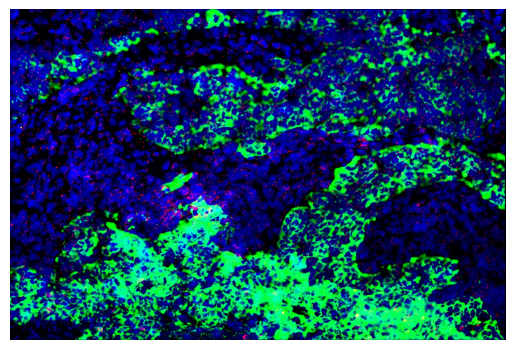

In [26]:
img = sp.get_image('022')
if img.ndim == 3:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis("off")
plt.show()

In [27]:
sp.load_all_images()
print(sp)
sp.unload_all_images()
print(sp)


Loading all 20 images...
✓ Loaded 20 images
spatioloji object
  Cells: 39,939
  Genes: 979
  FOVs:  20
  Images: 20 (20 loaded)

Unloading all images...
✓ Images unloaded (lazy loading available)
spatioloji object
  Cells: 39,939
  Genes: 979
  FOVs:  20
  Images: 20 (0 loaded)


In [28]:
sp.images.summary()

{'n_total': 20,
 'n_loaded': 0,
 'total_size_mb': np.float64(1142.2265625),
 'loaded_size_mb': 0,
 'lazy_load': True,
 'cache_size': 20}

In [29]:
custom_config = sj.data.QCConfig(
    # Negative probe QC
    alpha_neg_probe=0.01,           # Significance level for Grubbs test
    pct_counts_neg_max=0.1,         # Max 10% counts from negative probes

    # Cell area QC
    alpha_cell_area=0.01,           # Significance level for area outliers

    # Cell metrics QC
    pct_counts_mt_max=0.25,         # Max 25% mitochondrial counts
    ratio_counts_genes_min=1.0,     # Min ratio of counts to genes
    total_counts_min=20,            # Min total counts per cell

    # Gene filtering QC
    gene_filter_method='min_cells',
    gene_min_cells=50,

    # Output settings
    output_dir="./my_qc_output/",   # Where to save QC results
    save_plots=True                 # Whether to save plots
)
qc = sj.data.spatioloji_qc(sp, config = custom_config)
filtered_sp = qc.run_qc_pipeline()

Calculating QC metrics...
  ✓ Calculated metrics for 39939 cells

QC PIPELINE

[QC] Negative Probes
  ✓ No outliers detected

[QC] Cell Area
  ✗ Detected outlier: 018_169

[QC] Cell Metrics

  Metrics Summary:
       ratio_counts_genes  total_counts  pct_counts_mt  pct_counts_NegProbe
count        39855.000000  39939.000000        39939.0         39939.000000
mean             1.848564    201.482486            0.0             0.317589
std              0.473246    169.078811            0.0             1.053560
min              1.000000      0.000000            0.0             0.000000
25%              1.492063     78.000000            0.0             0.000000
50%              1.800000    156.000000            0.0             0.000000
75%              2.145039    279.000000            0.0             0.322581
max              4.687500   1624.000000            0.0           100.000000

[QC] FOV Metrics

  FOV Summary:
     n_cells  avg_transcripts  median_transcripts
fov                   

In [30]:
# Get non-negative probe genes
non_neg_genes = filtered_sp.gene_index[~filtered_sp.gene_meta['NegProbe']]

# Subset to remove negative probes
filtered_sp_no_neg = filtered_sp.subset_by_genes(non_neg_genes.tolist())
filtered_sp_no_neg


Subsetting by genes: 960 genes requested

Initializing spatioloji
[1/11] Master indices: 25,368 cells × 960 genes
[2/11] Expression matrix: sparse (26.0 MB)
[3/10] Cell metadata: 30 columns
[4/11] Gene metadata: 5 columns
[5/11] Spatial coordinates: 25368 cells
[6/11] Polygons: 625951 vertices for 25368 cells
[7/11] Images: 20 total, 0 loaded
[8/11] FOV system: 20 FOVs
[9/11] Index maps created
[10/11] Validation: ✓ All consistent
[11/11] Layers and Embeddings initialized (empty)

Spatioloji Object Summary:
  Cells:              25,368
  Genes:              960
  FOVs:               20
  Images:             20 (0 loaded)
  Original Expression:         sparse
  Has polygons:       True
  Memory (approx):    128.8 MB

✓ Created subset: 960 genes


spatioloji object
  Cells: 25,368
  Genes: 960
  FOVs:  20
  Images: 20 (0 loaded)

In [31]:
filtered_sp_no_neg.to_pickle("./my_qc_output/data/filtered_spatioloji.pkl")


Saving spatioloji to: my_qc_output/data/filtered_spatioloji.pkl
✓ Saved (71.3 MB)
